<a href="https://colab.research.google.com/github/shawngraham/latinepi/blob/main/training_spacy_model_for_latin_epigraphy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

So, normally you would mark up each inscription with annotations indicating the starting character and ending character position for each piece of data you want - name of the deceased, age at death, whatever. There are platforms that can help you do this, but it can take a long time and you'd have to pay someone for their time.

Here, I'm trying a different approach where I am counting on the highly formulaic nature of Roman epigraphy. I have generated a few hundred 'inscriptions' and then directed an LLM to do the annotation work. Then I use that data to create an entity extraction model with spaCy. Once such a model is created, it's very deterministic, unlike an LLM which might get creative on us. It's also rather small and can be run on a variety of regular computers or in Colab.

(On the other hand, the same regularity that permits me to create synthethic data with a commercial llm could probably just jump from reading the inscription to creating the structured data we're after.)

Originally I built this with the spacy english language model, but obviously that's not great. So trying with Patrick Burns' [LatinCy](https://diyclassics.github.io/latincy-book/) model

In [1]:
!mkdir assets         # To store your raw data files (jsonl, csv)
!mkdir configs        # To store configuration files
!mkdir scripts        # To store helper scripts (like data conversion)
!mkdir training       # To store the output of the training process
!mkdir corpus         # To store the processed .spacy files

In [2]:
!ls

assets	configs  corpus  sample_data  scripts  training


In [ ]:
#!pip install -U spacy #already in colab
#!python -m spacy download en_core_web_lg
#!pip install "la-core-web-sm @ https://huggingface.co/latincy/la_core_web_sm/resolve/main/la_core_web_sm-any-py3-none-any.whl"
!pip install "la-core-web-lg @ https://huggingface.co/latincy/la_core_web_lg/resolve/main/la_core_web_lg-any-py3-none-any.whl"
#
# this is what we're going to retrain.

In [ ]:
!pip install spacy-transformers

In [ ]:
# then you have to run this. It will say things have crashed. Ignore and continue.
import os
os.kill(os.getpid(), 9)

In [79]:
# start with some synthethic training annotations

!wget https://gist.githubusercontent.com/shawngraham/f44663efc80916a75c736a38f024b371/raw/9b1d724d19b30ded168268af0fd959dccaae521e/synthetic-training.jsonl -O assets/synthethic-training.jsonl

## and some synthetic testing data
#!wget https://gist.githubusercontent.com/shawngraham/3633224a209ab01f650f9dee9183888d/raw/9cc9dfeb566dc8465d744e6745af98af363a227c/testing-epigraphs-synthetic.csv -O assets/test-fake-epigraphs.csv

--2025-11-18 19:53:57--  https://gist.githubusercontent.com/shawngraham/f44663efc80916a75c736a38f024b371/raw/9b1d724d19b30ded168268af0fd959dccaae521e/synthetic-training.jsonl
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 161705 (158K) [text/plain]
Saving to: ‘assets/synthethic-training.jsonl’

assets/synthethic-t 100%[===================>] 157.92K  --.-KB/s    in 0.02s   

2025-11-18 19:53:58 (10.2 MB/s) - ‘assets/synthethic-training.jsonl’ saved [161705/161705]



## prepare data

In [80]:
# # scripts/convert_csv_to_jsonl.py
# # only if your original data is in csv format

# import pandas as pd
# import json
# import ast # Abstract Syntax Tree module to safely evaluate string-formatted lists

# def convert_csv_to_jsonl(input_path, output_path):
#     """
#     Converts a CSV with epigraphic annotations to a JSONL file
#     compatible with the spaCy training pipeline.
#     """
#     try:
#         df = pd.read_csv(input_path)
#     except FileNotFoundError:
#         print(f"Error: The file at {input_path} was not found.")
#         return

#     with open(output_path, 'w') as f:
#         for index, row in df.iterrows():
#             # Safely evaluate the string representation of the list
#             try:
#                 # ast.literal_eval is safer than eval() for this purpose
#                 annotation_list = ast.literal_eval(row['annotations'])
#             except (ValueError, SyntaxError):
#                 print(f"Warning: Could not parse annotations for row {index + 1}. Skipping.")
#                 continue

#             # Create the final JSON structure for each line
#             json_record = {
#                 "id": row['id'],
#                 "text": row['text'],
#                 "transcription": row['transcription'],
#                 # The final JSONL needs the annotations nested inside a dictionary
#                 "annotations": {"annotations": annotation_list}
#             }

#             # Write the JSON object as a string on a new line
#             f.write(json.dumps(json_record) + '\n')

#     print(f" Successfully converted {input_path} to {output_path}")

# # --- Main execution ---
# if __name__ == '__main__':
#     # Define the input CSV and output JSONL file paths
#     csv_file = 'assets/training-annotations-synthetic.csv'
#     jsonl_file = 'assets/train.jsonl'

#     # Run the conversion
#     convert_csv_to_jsonl(csv_file, jsonl_file)

 Successfully converted assets/training-annotations-synthetic.csv to assets/train.jsonl


In [81]:
# scripts/partition_data.py (Separates clean data from data that needs fixing)

import spacy
import json
from spacy.tokens import Doc

def get_annotation_spans(record):
    """Safely navigates the nested dictionary to find the list of annotations."""
    try: return record['annotations']['annotations']['annotations']
    except (KeyError, TypeError):
        try: return record['annotations']['annotations']
        except (KeyError, TypeError): return []

def partition_data(input_path, clean_output_path, needs_fixing_output_path):
    """
    Reads a JSONL file and splits it into two files: one with clean, alignable
    records, and one with records that contain at least one unalignable annotation.
    """
    #nlp = spacy.blank("en")
    nlp = spacy.load('la_core_web_lg')
    clean_records = []
    fix_records = []

    print(f"--- Starting data partitioning for '{input_path}' ---")

    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            try: record = json.loads(line)
            except json.JSONDecodeError: continue

            text = record.get('transcription', '')
            if not text:
                fix_records.append(record) # A record with no text needs fixing
                continue

            annotations = get_annotation_spans(record)

            # A record with no annotations is considered clean
            if not isinstance(annotations, list) or not annotations:
                clean_records.append(record)
                continue

            doc = nlp.make_doc(text)
            is_record_clean = True # Assume the record is clean until proven otherwise

            for entity in annotations:
                if not isinstance(entity, list) or len(entity) != 3:
                    is_record_clean = False
                    break # Malformed entity taints the whole record

                start, end, label = entity

                # Try all alignment strategies
                span = doc.char_span(start, end, label=label, alignment_mode="expand")
                if span is None: span = doc.char_span(start + 1, end + 1, label=label, alignment_mode="expand")
                if span is None: span = doc.char_span(start - 1, end - 1, label=label, alignment_mode="expand")

                # If an entity STILL fails alignment, the whole record is tainted
                if span is None:
                    is_record_clean = False
                    break # No need to check other entities in this record

            # After checking all entities, sort the record into the correct list
            if is_record_clean:
                clean_records.append(record)
            else:
                fix_records.append(record)

    # Write the clean records file
    with open(clean_output_path, 'w', encoding='utf-8') as f:
        for record in clean_records:
            f.write(json.dumps(record) + '\n')

    # Write the records that need fixing
    with open(needs_fixing_output_path, 'w', encoding='utf-8') as f:
        for record in fix_records:
            f.write(json.dumps(record) + '\n')

    print("\nPartitioning complete.")
    print(f" - Total Records Processed: {len(clean_records) + len(fix_records)}")
    print(f" - Clean Records: {len(clean_records)}")
    print(f" - Records Needing Fixes: {len(fix_records)}")
    print(f"Clean data saved to '{clean_output_path}'")
    print(f"Data to be fixed saved to '{needs_fixing_output_path}'")


# --- Run the Partitioning Script ---
#INPUT_FILE = "assets/train.jsonl"
INPUT_FILE = "assets/synthethic-training.jsonl"
CLEAN_OUTPUT_FILE = "assets/train_clean.jsonl"
FIX_OUTPUT_FILE = "assets/train_needs_fixing.jsonl"

partition_data(INPUT_FILE, CLEAN_OUTPUT_FILE, FIX_OUTPUT_FILE)

--- Starting data partitioning for 'assets/synthethic-training.jsonl' ---

Partitioning complete.
 - Total Records Processed: 463
 - Clean Records: 463
 - Records Needing Fixes: 0
Clean data saved to 'assets/train_clean.jsonl'
Data to be fixed saved to 'assets/train_needs_fixing.jsonl'


In [82]:
# scripts/split_data.py (Splits a JSONL file into train and dev sets)

import json
from sklearn.model_selection import train_test_split

def split_data(input_path, train_output_path, dev_output_path, dev_size=0.2):
    """
    Reads a JSONL file and splits its records into training and development sets.
    """
    print(f"--- Splitting data from '{input_path}' ---")

    # Read all lines from the source file
    with open(input_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    if len(lines) < 2:
        print("Warning: Not enough data to split. Need at least 2 records.")
        return

    # Use train_test_split to randomly shuffle and split the lines
    train_lines, dev_lines = train_test_split(lines, test_size=dev_size, random_state=42)

    # Write the training set
    with open(train_output_path, 'w', encoding='utf-8') as f:
        for line in train_lines:
            f.write(line)

    # Write the development set
    with open(dev_output_path, 'w', encoding='utf-8') as f:
        for line in dev_lines:
            f.write(line)

    print("\n✅ Data splitting complete.")
    print(f"   - Total Records: {len(lines)}")
    print(f"   - Training Records: {len(train_lines)} -> {train_output_path}")
    print(f"   - Development Records: {len(dev_lines)} -> {dev_output_path}")

# --- Run the Splitting Script ---
INPUT_FILE = "assets/train_clean.jsonl"
TRAIN_SPLIT_FILE = "assets/train_split.jsonl"
DEV_SPLIT_FILE = "assets/dev_split.jsonl"

split_data(INPUT_FILE, TRAIN_SPLIT_FILE, DEV_SPLIT_FILE)

--- Splitting data from 'assets/train_clean.jsonl' ---

✅ Data splitting complete.
   - Total Records: 463
   - Training Records: 370 -> assets/train_split.jsonl
   - Development Records: 93 -> assets/dev_split.jsonl


In [83]:
# # scripts/align_annotations.py


import spacy
import json
from spacy.tokens import Doc

def get_annotation_spans(record):
    """
    Retrieves annotations whether they are a flat list (your current data)
    or nested in a dictionary (LabelStudio style).
    """
    raw = record.get('annotations', [])

    # Case 1: It is already a list (Your current format)
    if isinstance(raw, list):
        return raw

    # Case 2: It is a dictionary (Nested format)
    if isinstance(raw, dict):
        try:
            return raw.get('annotations', [])
        except (AttributeError, TypeError):
            pass

    return []

def align_annotations(input_path, output_path):
    # Load the model for tokenization reference
    nlp = spacy.load('la_core_web_lg')
    corrected_records = []

    # Stats tracking
    stats = {
        "total_records": 0,
        "malformed_ents": 0,
        "unaligned_ents": 0,
        "auto_fixed_ents": 0,
        "perfect_ents": 0
    }

    with open(input_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            try:
                record = json.loads(line)
                stats["total_records"] += 1
            except json.JSONDecodeError:
                continue

            # Ensure we are targeting the field that matches the character offsets
            # Based on your example: 0-11 "DIS MANIBUS" matches 'transcription', not 'text'
            text = record.get('transcription', '')
            if not text:
                continue

            annotations = get_annotation_spans(record)

            doc = nlp.make_doc(text)
            corrected_ents = []

            for entity in annotations:
                # Safety check
                if not isinstance(entity, list) or len(entity) != 3:
                    stats["malformed_ents"] += 1
                    continue

                start, end, label = entity

                span = None

                # Attempt A: Original indices
                span = doc.char_span(start, end, label=label, alignment_mode="expand")
                if span is not None:
                    stats["perfect_ents"] += 1

                # Attempt B: +1 shift
                if span is None:
                    span = doc.char_span(start + 1, end + 1, label=label, alignment_mode="expand")
                    if span is not None:
                        stats["auto_fixed_ents"] += 1

                # Attempt C: -1 shift
                if span is None:
                    span = doc.char_span(start - 1, end - 1, label=label, alignment_mode="expand")
                    if span is not None:
                        stats["auto_fixed_ents"] += 1

                # Final Decision
                if span is not None:
                    corrected_ents.append([span.start_char, span.end_char, label])
                else:
                    # Optional: Print failures to debug specific lines
                    # print(f"Could not align: '{text[start:end]}' ({label}) in text")
                    stats["unaligned_ents"] += 1

            # --- UPDATE RECORD ---
            # We save it back as a flat list to keep it simple and matching input format
            record['annotations'] = corrected_ents
            corrected_records.append(record)

    # Write output
    with open(output_path, 'w', encoding='utf-8') as f:
        for record in corrected_records:
            f.write(json.dumps(record) + '\n')

    print(f"\n✅ Alignment complete for {input_path}.")
    print(f"   - Processed Records: {stats['total_records']}")
    print(f"   - Perfect Annotations: {stats['perfect_ents']}")
    print(f"   - Fixed Offsets: {stats['auto_fixed_ents']}")
    print(f"   - Malformed/Skipped: {stats['malformed_ents']}")
    print(f"   - Unalignable (Dropped): {stats['unaligned_ents']}")

# Run it
align_annotations('assets/train_split.jsonl', 'assets/train_aligned.jsonl')
align_annotations('assets/dev_split.jsonl', 'assets/dev_aligned.jsonl')


✅ Alignment complete for assets/train_split.jsonl.
   - Processed Records: 370
   - Perfect Annotations: 2730
   - Fixed Offsets: 0
   - Malformed/Skipped: 0
   - Unalignable (Dropped): 0

✅ Alignment complete for assets/dev_split.jsonl.
   - Processed Records: 93
   - Perfect Annotations: 671
   - Fixed Offsets: 0
   - Malformed/Skipped: 0
   - Unalignable (Dropped): 0


In [84]:
# # scripts/prepare_data.py


import spacy
import json
from spacy.tokens import DocBin
from spacy.util import filter_spans

def get_annotation_spans(record):
    raw = record.get('annotations')
    if isinstance(raw, list): return raw
    try: return raw['annotations']
    except (KeyError, TypeError): return []

def create_spacy_file(input_path, output_path):
    nlp = spacy.load('la_core_web_lg')
    db = DocBin()

    stats = {
        "docs": 0,
        "total_ents": 0,
        "dropped_ents": 0
    }

    print(f"--- Processing '{input_path}' ---")

    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                record = json.loads(line)
            except json.JSONDecodeError:
                continue

            text = record.get('transcription')
            if not text:
                continue

            doc = nlp.make_doc(text)
            ents = []
            annotations = get_annotation_spans(record)

            if isinstance(annotations, list):
                for entity in annotations:
                    if len(entity) != 3: continue
                    start, end, label = entity

                    span = doc.char_span(start, end, label=label, alignment_mode="expand")

                    if span is not None:
                        ents.append(span)
                    else:
                        stats["dropped_ents"] += 1
                        # Optional: print what was dropped to debug
                        print(f"Dropping invalid span: [{start}:{end}] in '{text[:20]}...'")

            # Remove duplicates/overlaps
            original_count = len(ents)
            filtered_ents = filter_spans(ents)

            if len(filtered_ents) < original_count:
                stats["dropped_ents"] += (original_count - len(filtered_ents))

            doc.ents = filtered_ents
            stats["total_ents"] += len(filtered_ents)
            stats["docs"] += 1
            db.add(doc)

    db.to_disk(output_path)

    print(f"✅ Saved {output_path}")
    print(f"   - Documents: {stats['docs']}")
    print(f"   - Total Entities: {stats['total_ents']} (Avg: {stats['total_ents']/stats['docs']:.1f} per doc)")
    print(f"   - Dropped/Failed: {stats['dropped_ents']}")

# --- Execute ---
create_spacy_file('assets/train_aligned.jsonl', './corpus/train.spacy')
create_spacy_file('assets/dev_aligned.jsonl', './corpus/dev.spacy')

--- Processing 'assets/train_aligned.jsonl' ---
✅ Saved ./corpus/train.spacy
   - Documents: 370
   - Total Entities: 1802 (Avg: 4.9 per doc)
   - Dropped/Failed: 928
--- Processing 'assets/dev_aligned.jsonl' ---
✅ Saved ./corpus/dev.spacy
   - Documents: 93
   - Total Entities: 426 (Avg: 4.6 per doc)
   - Dropped/Failed: 245


## Train the Model

In [95]:
import spacy
from pathlib import Path

# --- 1. Generate the base config ---
!python -m spacy init config configs/config.cfg --lang la --pipeline tok2vec,ner --optimize accuracy --force

print("✅ Base 'config.cfg' generated.")

# --- 2. Load and Modify ---
config_path = Path("configs/config.cfg")
config = spacy.util.load_config(config_path)

# Define the model we are using
LATIN_MODEL = "la_core_web_lg"

# --- Part A: Initialize Vectors (CRITICAL FOR LG MODELS) ---
# This loads the 300-dim vectors into the vocab so the tok2vec layer can find them.
config["initialize"]["vectors"] = LATIN_MODEL

# --- Part B: Source the tok2vec component ---
config["components"]["tok2vec"] = {
    "source": LATIN_MODEL,
    "component": "tok2vec"
}

# --- Part C: Connect NER to the vectors ---
# ERROR CORRECTION: The tok2vec OUTPUT width is 96, even if the input vectors are 300.
config["components"]["ner"]["model"]["tok2vec"] = {
    "@architectures": "spacy.Tok2VecListener.v1",
    "width": 96,  # <--- Reverted to 96. This matches the output of la_core_web_lg.
    "upstream": "tok2vec"
}

config["nlp"]["batch_size"] = 200

# --- Part D: Paths and Freezing ---
config["paths"]["train"] = "./corpus/train.spacy"
config["paths"]["dev"] = "./corpus/dev.spacy"

# Freeze tok2vec so we don't ruin the pretrained Latin intelligence
#config["training"]["frozen_components"] = ["tok2vec"]
# or unfreeze it, see what happens
config["training"]["frozen_components"] = []
config["training"]["max_epochs"]= 100
# Mark it as annotating so it actually runs
config["training"]["annotating_components"] = ["tok2vec"]

# --- 3. Save ---
config.to_disk(config_path)

print(f"✅ Config updated for {LATIN_MODEL}. Listener width set to 96 (correct output dim).")

ℹ Generated config template specific for your use case
- Language: la
- Pipeline: ner
- Optimize for: accuracy
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
configs/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy
✅ Base 'config.cfg' generated.
✅ Config updated for la_core_web_lg. Listener width set to 96 (correct output dim).


In [96]:
# Start the training process!
!python -m spacy train configs/config.cfg --output ./training/ --gpu-id 0

ℹ Saving to output directory: training
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Set annotations on update for: ['tok2vec']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     76.23   19.74   25.27   16.20    0.20
  5     200        161.75   5016.42   86.74   88.32   85.21    0.87
 12     400        154.83   2110.54   89.13   89.76   88.50    0.89
 20     600        201.80   1797.31   88.60   87.79   89.44    0.89
 30     800        110.59   1658.81   89.20   88.28   90.14    0.89
 43    1000        118.37   1814.81   88.79   88.37   89.20    0.89
 58    1200        119.99   2013.56   89.02   88.60   89.44    0.89
 77    1400        144.55   2340.61   89.46   89.

## Interpreting those numbers:
+ (Epoch): An epoch is one complete pass through your entire training dataset. The training process shows you the state of the model after E epochs have been completed.

+ (Step): This is the number of batches or steps the model has processed so far.

+ LOSS TOK2VEC (Loss for Token-to-Vector): This component is responsible for learning meaningful numerical representations of your words. Like any "loss" value, you want to see it decrease over time. Its fluctuation is normal as it and the NER component influence each other.

+ LOSS NER (Loss for Named Entity Recognition): This is the most important loss metric for the project. It measures how "wrong" the model's entity predictions are. A lower number is better. If NER loss dropped from a massive 3064 to just 66.73, that would be a clear indication of successful learning.

+ ENTS_P (Entities Precision): Of all the entities the model predicted, this is the percentage that were actually correct. A score of 100.00 means the model made no false positive predictions.

+ ENTS_R (Entities Recall): Of all the actual entities in the data, this is the percentage that the model successfully found. A score of 100.00 means the model made no false negative predictions (it didn't miss anything).

+ ENTS_F (Entities F-score): This is the harmonic mean of Precision and Recall, and it's generally considered the single most important metric for evaluating a model's performance. It gives you a balanced measure of its accuracy.

+ SCORE: This is the final score spaCy uses to evaluate the pipeline. For an NER project, this is the ENTS_F score. The training process will save the model from the epoch with the highest score as model-best.

+ Perfect Scores and Overfitting: If the model achieved a perfect F-score of 100.00 on the training data then it has essentially memorized your training set. In many machine learning scenarios, this would be a major red flag for a problem called overfitting. Overfitting is when a model learns its training data so perfectly that it fails to generalize to new, unseen data. In the case of Roman funerary inscriptions, these are highly formulaic. The patterns for names, military units, and ages are quite regular. With a dataset of 197 records, a modern model should be able to memorize these patterns.

In [97]:
# testing for overfitting
import spacy
from spacy.scorer import Scorer
from spacy.training import Example
from spacy.tokens import DocBin

def evaluate_detailed(model_path, dev_data_path):
    # Load the best model
    nlp = spacy.load(model_path)

    # Load the Dev data
    db = DocBin().from_disk(dev_data_path)
    docs = list(db.get_docs(nlp.vocab))

    examples = []
    for doc in docs:
        # Create an Example object (predicted vs reference)
        pred_doc = nlp(doc.text)
        examples.append(Example(pred_doc, doc))

    # Calculate scores
    scorer = Scorer()
    scores = scorer.score(examples)

    # Print Global Score
    print(f"--- Global Results ---")
    print(f"Precision: {scores['ents_p']:.2f}")
    print(f"Recall:    {scores['ents_r']:.2f}")
    print(f"F-Score:   {scores['ents_f']:.2f}")

    # Print Per-Label Score
    print(f"\n--- Per-Label Breakdown ---")
    print(f"{'LABEL':<30} {'PREC':<10} {'REC':<10} {'F-SCORE':<10}")
    print("-" * 60)

    for label, metrics in scores['ents_per_type'].items():
        print(f"{label:<30} {metrics['p']:.2f}       {metrics['r']:.2f}       {metrics['f']:.2f}")

# Run evaluation
evaluate_detailed("training/model-best", "corpus/dev.spacy")

--- Global Results ---
Precision: 0.89
Recall:    0.90
F-Score:   0.89

--- Per-Label Breakdown ---
LABEL                          PREC       REC        F-SCORE   
------------------------------------------------------------
DEDICATION_TO_THE_GODS         0.97       0.97       0.97
NOMEN                          0.99       0.99       0.99
COGNOMEN                       0.90       0.89       0.90
AGE_PREFIX                     0.98       1.00       0.99
DEDICATOR_NAME                 1.00       1.00       1.00
BENE_MERENTI                   0.35       0.39       0.37
FUNERARY_FORMULA               1.00       1.00       1.00
RELATIONSHIP                   0.14       0.33       0.20
MILITARY_UNIT                  0.59       0.54       0.57
TRIBE                          1.00       1.00       1.00
OCCUPATION                     1.00       0.50       0.67
VERB                           0.25       0.25       0.25
AGE_DAYS                       0.00       0.00       0.00
AGE_YEARS            

In [103]:
import spacy
from spacy.scorer import Scorer
from spacy.training import Example
from spacy.tokens import DocBin

def evaluate_final(model_path, dev_data_path):
    print(f"--- Evaluating {model_path} ---")
    nlp = spacy.load(model_path)
    db = DocBin().from_disk(dev_data_path)
    docs = list(db.get_docs(nlp.vocab))

    examples = []
    for doc in docs:
        examples.append(Example(nlp(doc.text), doc))

    scores = Scorer().score(examples)

    print(f"{'LABEL':<30} {'PREC':<8} {'REC':<8} {'F1':<8}")
    print("-" * 60)
    for label, metrics in scores['ents_per_type'].items():
        print(f"{label:<30} {metrics['p']:.2f}     {metrics['r']:.2f}     {metrics['f']:.2f}")

evaluate_final("training/model-best", "corpus/dev.spacy")

--- Evaluating training/model-best ---
LABEL                          PREC     REC      F1      
------------------------------------------------------------
DEDICATION_TO_THE_GODS         0.97     0.97     0.97
NOMEN                          0.99     0.99     0.99
COGNOMEN                       0.90     0.89     0.90
AGE_PREFIX                     0.98     1.00     0.99
DEDICATOR_NAME                 1.00     1.00     1.00
BENE_MERENTI                   0.35     0.39     0.37
FUNERARY_FORMULA               1.00     1.00     1.00
RELATIONSHIP                   0.14     0.33     0.20
MILITARY_UNIT                  0.59     0.54     0.57
TRIBE                          1.00     1.00     1.00
OCCUPATION                     1.00     0.50     0.67
VERB                           0.25     0.25     0.25
AGE_DAYS                       0.00     0.00     0.00
AGE_YEARS                      0.00     0.00     0.00
FILIATION                      0.67     0.67     0.67


In [118]:
import spacy
import pandas as pd
import re

# 1. Load Model
print("⏳ Loading Model...")
nlp = spacy.load("training/model-best")

# 2. Stricter Regex (The "Calculator")
# Only match specific keywords like ANNIS/MENS.
# We removed single letters (A, M, D) unless they are followed immediately by a dot to avoid matching names like "Marcus".
REGEX_YEARS = re.compile(r'\b(VIXIT|VIX|ANNIS|ANN|AN|A\.)\s*([IVXLCDM]+)\b', re.IGNORECASE)
REGEX_MONTHS = re.compile(r'\b(MENSIBUS|MENS|MEN|M\.)\s*([IVXLCDM]+)\b', re.IGNORECASE)
REGEX_DAYS = re.compile(r'\b(DIEBUS|DIE|D\.)\s*([IVXLCDM]+)\b', re.IGNORECASE)

# 3. Clean & Normalize Text
def normalize_text(text):
    if pd.isna(text) or text == "": return ""
    text = str(text)

    # Standardize Leiden Brackets
    text = re.sub(r"\[\s*-+\??\s*\]", "", text) # Remove [---]
    text = re.sub(r"-+\]", "", text)
    text = re.sub(r"\[-+", "", text)
    text = text.replace("/", " ").replace("(", "").replace(")", "")
    text = text.replace("[", "").replace("]", "").replace("?", "")
    text = re.sub(r"\s+", " ", text).strip()

    # CRITICAL FIX: Latin Inscriptions are traditionally processed in UPPERCASE
    # This matches how the vectors were likely trained.
    return text.upper()

def extract_data(text):
    data = {}
    doc = nlp(text)

    # --- A. Neural Network Extraction ---
    ents_by_label = {}

    for ent in doc.ents:
        # Skip specific labels we handle with Regex
        if ent.label_ in ["AGE_YEARS", "AGE_MONTHS", "AGE_DAYS", "AGE_PREFIX"]:
            continue

        # Organize by label
        if ent.label_ not in ents_by_label:
            ents_by_label[ent.label_] = []
        ents_by_label[ent.label_].append(ent.text)

    for label, values in ents_by_label.items():
        data[label] = "; ".join(values)

    # --- B. Regex Extraction ---
    # Years
    match_yr = REGEX_YEARS.search(text)
    if match_yr:
        data["AGE_YEARS"] = match_yr.group(2)

    # Months
    match_mo = REGEX_MONTHS.search(text)
    if match_mo:
        data["AGE_MONTHS"] = match_mo.group(2)

    # Days
    match_da = REGEX_DAYS.search(text)
    if match_da:
        data["AGE_DAYS"] = match_da.group(2)

    return data

# --- Execution ---
input_csv = "assets/inscriptions.csv"
output_csv = "assets/final_database_fixed.csv"

df = pd.read_csv(input_csv)
results = []

print(f"🚀 Processing {len(df)} records...")

for index, row in df.iterrows():
    # Prefer diplomatic text if available, otherwise transcription
    raw = row.get('text', '')
    if not raw or pd.isna(raw):
        raw = row.get('transcription', '')

    clean_text = normalize_text(raw)

    if len(clean_text) < 3: continue

    info = extract_data(clean_text)
    info['id'] = row.get('id')
    info['clean_text'] = clean_text # Inspect this to ensure it is UPPERCASE
    results.append(info)

# --- Save ---
results_df = pd.DataFrame(results)

# Column Ordering Logic
desired_order = [
    'id', 'clean_text',
    'DEDICATION_TO_THE_GODS',
    'NOMEN', 'COGNOMEN', 'PRAENOMEN', 'DECEASED_NAME',
    'AGE_YEARS', 'AGE_MONTHS', 'AGE_DAYS',
    'DEDICATOR_NAME', 'RELATIONSHIP',
    'MILITARY_UNIT', 'OCCUPATION', 'TRIBE'
]

# Find which columns actually exist in the results
existing_cols = results_df.columns.tolist()
final_cols = [c for c in desired_order if c in existing_cols] + [c for c in existing_cols if c not in desired_order]

results_df = results_df[final_cols]
results_df.to_csv(output_csv, index=False)

print("✅ Done. Check 'clean_text' column - it should be ALL CAPS.")

⏳ Loading Model...
🚀 Processing 500 records...
✅ Done. Check 'clean_text' column - it should be ALL CAPS.


## let's get latinepi tools and download some real data

In [ ]:
!git clone https://github.com/shawngraham/latinepi.git
%cd latinepi

# Install the package (includes pandas and requests dependencies)
!pip install -e .
%cd ..

In [ ]:
# Search for 1st century AD inscriptions
print("🔍 Searching for 1st century AD inscriptions...\n")

!latinepi \
    --search-edh \
    --search-year-from 1 \
    --search-year-to 100 \
    --search-limit 500 \
    --download-dir edh_downloads/first_century/

# Check results
century_files = list(Path('edh_downloads/first_century').glob('*.json'))
print(f"\n✅ Downloaded {len(century_files)} inscriptions from 1st century AD")


In [18]:
import json
import csv
from pathlib import Path

def ingest_inscriptions_to_csv(input_dir, output_file):
    """
    Reads all JSON files from a directory and exports specific fields to a CSV.

    Args:
        input_dir (str): Path to the folder containing JSON files.
        output_file (str): Path where the CSV should be saved.
    """
    source_path = Path(input_dir)
    output_path = Path(output_file)

    # List to hold extracted data
    extracted_data = []

    # Get all .json files in the directory
    json_files = list(source_path.glob("*.json"))

    if not json_files:
        print(f"⚠️ No JSON files found in directory: {input_dir}")
        return

    print(f"Processing {len(json_files)} files from {input_dir}...")

    for file_path in json_files:
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f)

                # Extract the required fields.
                # .get() returns an empty string if the field is missing.
                row = {
                    "id": data.get("id", ""),
                    "text": data.get("diplomatic_text", ""), # Mapping diplomatic_text -> text
                    "transcription": data.get("transcription", "")
                }

                extracted_data.append(row)

        except json.JSONDecodeError:
            print(f"❌ Error decoding JSON: {file_path.name}")
        except Exception as e:
            print(f"❌ Error processing {file_path.name}: {e}")

    # Write to CSV
    try:
        with open(output_path, "w", newline="", encoding="utf-8") as csvfile:
            fieldnames = ["id", "text", "transcription"]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            writer.writeheader()
            writer.writerows(extracted_data)

        print(f"✅ Successfully saved {len(extracted_data)} records to '{output_file}'")

    except Exception as e:
        print(f"❌ Error writing CSV file: {e}")

# --- Execution ---
# Adjust the path below if your folder name is slightly different
input_folder = "edh_downloads/first_century"
output_csv = "assets/inscriptions.csv"

# Ensure the output directory exists
Path("corpus").mkdir(exist_ok=True)

ingest_inscriptions_to_csv(input_folder, output_csv)

Processing 500 files from edh_downloads/first_century...
✅ Successfully saved 500 records to 'assets/inscriptions.csv'


In [66]:
import spacy
import pandas as pd
import re

# --- 1. The Cleaning Function ---
def clean_leiden_text(text):
    """
    Converts Epigraphic Transcription (Leiden) to Natural Latin.
    Example: "D(is) M(anibus) / [---]us" -> "Dis Manibus us"
    """
    if pd.isna(text) or text == "":
        return ""

    # Convert to string just in case
    text = str(text)

    # 1. Remove "Lost text" markers like [---], [---?], or ------
    # Matches brackets containing hyphens, with optional spaces or question marks
    text = re.sub(r"\[\s*-+\??\s*\]", "", text)
    # Matches loose hyphens at start/end of lines (e.g. ------])
    text = re.sub(r"-+\]", "", text)
    text = re.sub(r"\[-+", "", text)

    # 2. Replace line breaks "/" with space
    text = text.replace("/", " ")

    # 3. Remove parentheses () to keep the expansion
    # "D(is)" -> "Dis"
    text = text.replace("(", "").replace(")", "")

    # 4. Remove brackets [] to keep the restoration
    # "Cl]audi[us" -> "Claudius"
    text = text.replace("[", "").replace("]", "")

    # 5. Remove question marks inside words (uncertain readings)
    # "dom[um?]" -> "domum"
    text = text.replace("?", "")

    # 6. Collapse multiple spaces into one
    text = re.sub(r"\s+", " ", text).strip()

    #text = text.upper()

    return text

# --- 2. Load Data and Model ---
print("⏳ Loading data and model...")

# Load the CSV generated in the previous step
df = pd.read_csv("assets/inscriptions.csv")

# --- 3. Process the Inscriptions ---
print("🧹 Cleaning text and extracting entities...")

results = []

for index, row in df.iterrows():
    raw_text = row['transcription']

    # Apply cleaning
    clean_text = clean_leiden_text(raw_text)

    # Skip if text is empty after cleaning
    if not clean_text or len(clean_text) < 2:
        continue

    # Store result
    results.append({
        "id": row['id'],
        "clean_text": clean_text,
        "raw_transcription": raw_text
    })

# --- 4. Save Results ---
output_df = pd.DataFrame(results)
output_filename = "assets/cleaned_inscriptions.csv"
output_df.to_csv(output_filename, index=False)

print(f"✅ Done! Processed {len(results)} inscriptions.")
print(f"📂 Results saved to: {output_filename}")



⏳ Loading data and model...
🧹 Cleaning text and extracting entities...
✅ Done! Processed 500 inscriptions.
📂 Results saved to: assets/cleaned_inscriptions.csv


## Test the model or use it on new data

In [ ]:
# another bit of code to load the model in and clean things up.
import spacy
import pandas as pd
import json
from collections import defaultdict

# --- 1. Load your custom-trained model ---
print("Loading model from 'training/model-best'...")
nlp_ner = spacy.load("training/model-best")


# --- 2. Define input and output paths ---
#input_csv_path = "assets/test-fake-epigraphs.csv"
input_csv_path = "assets/cleaned_inscriptions.csv"
output_csv_path = "assets/results_wide.csv" # New filename for the wide format

try:
    df_new = pd.read_csv(input_csv_path)
except FileNotFoundError:
    print(f"Error: Input file not found at {input_csv_path}")
    df_new = pd.DataFrame() # Create an empty DataFrame to prevent a crash

# --- 3. Process data and collect results for a wide format ---
print(f"\n--- Applying model to data from '{input_csv_path}' ---")

# This list will hold a dictionary for each row in our final CSV
processed_rows = []

for index, row in df_new.iterrows():

    # We use 'clean_text' because that is what we want to feed the model.
    if 'clean_text' not in row or not isinstance(row['clean_text'], str):
        print(f"Skipping row {index} due to missing 'clean_text'.")
        continue

    text = row['clean_text'] #
    doc = nlp_ner(text)

    # Start building the dictionary for our output row
    # It includes the original data from the input file
    output_row = {
        "id": row.get('id', index),
        "text": row.get('text', ''),
        "transcription": text
    }

    # Use a defaultdict to easily collect multiple entities of the same type
    entities_by_label = defaultdict(list)
    if doc.ents:
        print(f"✅ Found entities in: '{text[:70]}...'")
        for ent in doc.ents:
            entities_by_label[ent.label_].append(ent.text)
    else:
        print(f"ℹ️ No entities found in: '{text[:70]}...'")

    # Now, pivot the collected entities into the output_row dictionary.
    # If multiple entities of the same type were found (e.g., two names),
    # they will be joined together with a semicolon.
    for label, texts in entities_by_label.items():
        output_row[label] = "; ".join(texts)

    # Add the completed row dictionary to our list
    processed_rows.append(output_row)


# --- 4. Write the collected data to a wide format CSV file ---
if processed_rows:
    try:
        # Convert the list of dictionaries directly into a pandas DataFrame
        # Pandas will automatically create columns for all unique entity labels found
        results_df = pd.DataFrame(processed_rows)

        # Reorder columns to have the source data first, for clarity
        # Get all unique entity labels found during processing
        entity_columns = sorted([col for col in results_df.columns if col not in ['id', 'text', 'transcription']])
        column_order = ['id', 'text', 'transcription'] + entity_columns

        # Ensure all columns exist before trying to reorder
        results_df = results_df.reindex(columns=column_order)

        # Save the DataFrame to a CSV file
        results_df.to_csv(output_csv_path, index=False)
        print(f"\n✅ Successfully saved wide-format results to {output_csv_path}")
    except Exception as e:
        print(f"Error saving CSV file: {e}")
else:
    print("ℹ️ No data was processed, so no CSV file was created.")

In [121]:
results_df

,id,clean_text,DEDICATION_TO_THE_GODS,NOMEN,COGNOMEN,PRAENOMEN,AGE_YEARS,AGE_MONTHS,AGE_DAYS,DEDICATOR_NAME,MILITARY_UNIT,OCCUPATION,TRIBE,VERB,BENE_MERENTI,FILIATION,FUNERARY_FORMULA
0,HD000010,D M L ASINI POLI SECVNDVS ET ORPHAEVS LIB P B M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SECVNDVS ET,NaN,NaN,NaN,NaN,NaN,NaN
1,HD000476,T AV S T L CRY ENES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HD000251,M PILI PRIMIG GRANIANI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HD000324,AVDI ITAE N AM CAELO OVANS DOM IVST VERV M C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HD000280,Ε ΗΘΙΚ A POSTYM A F SENECA V AN IV,NaN,NaN,NaN,NaN,IV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,HD000232,D M S P VELLEIVS DONATVS ET SIBI POMPEIAE AM P...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
495,HD000132,D M L VOCONIO VERO MIL COH VI PR | CASSI MIL A...,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496,HD000252,D M S L IVN O NESIPH ORVS AN LX P I S,NaN,NaN,NaN,NaN,LX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O,NaN
497,HD000119,K D L PETRE IVS VIC TOR ALI ARIVS D K M V S L M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TOR ALI ARIVS D,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--- Visualization 1: Entity Type Frequency ---


/tmp/ipython-input-2836028133.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=entity_counts.index, y=entity_counts.values, palette="viridis")


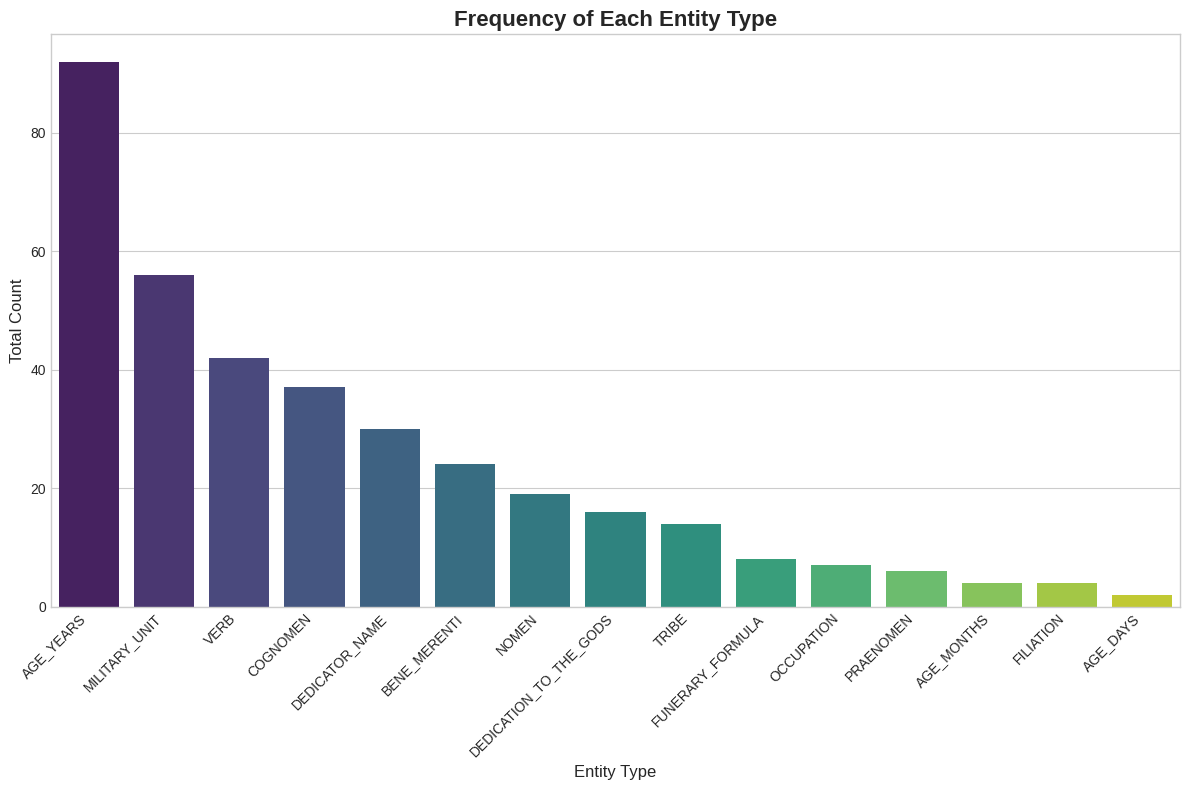



--- Visualization 2: Top 10 Most Common Nomen ---


/tmp/ipython-input-2836028133.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_occupations.values, y=top_occupations.index, orient='h', palette='magma')


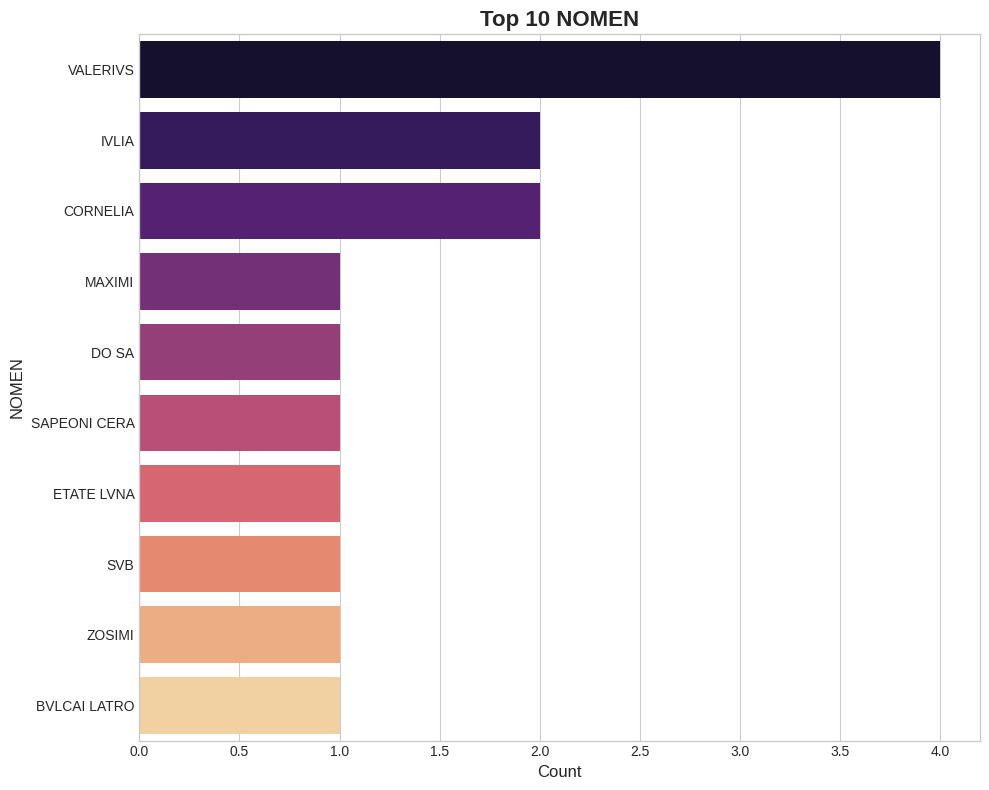



--- Visualization 3: Age Distribution of the Deceased ---


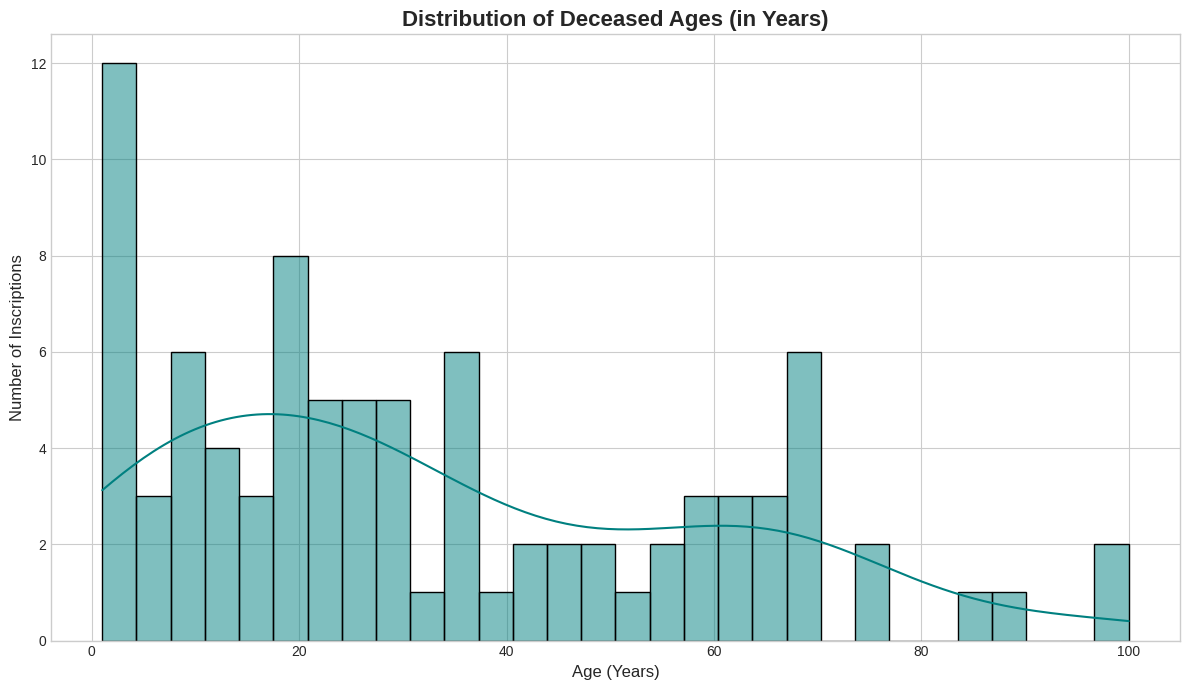



--- Visualization 2: Top 10 Most Common Tribe ---


/tmp/ipython-input-2836028133.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_occupations.values, y=top_occupations.index, orient='h', palette='magma')


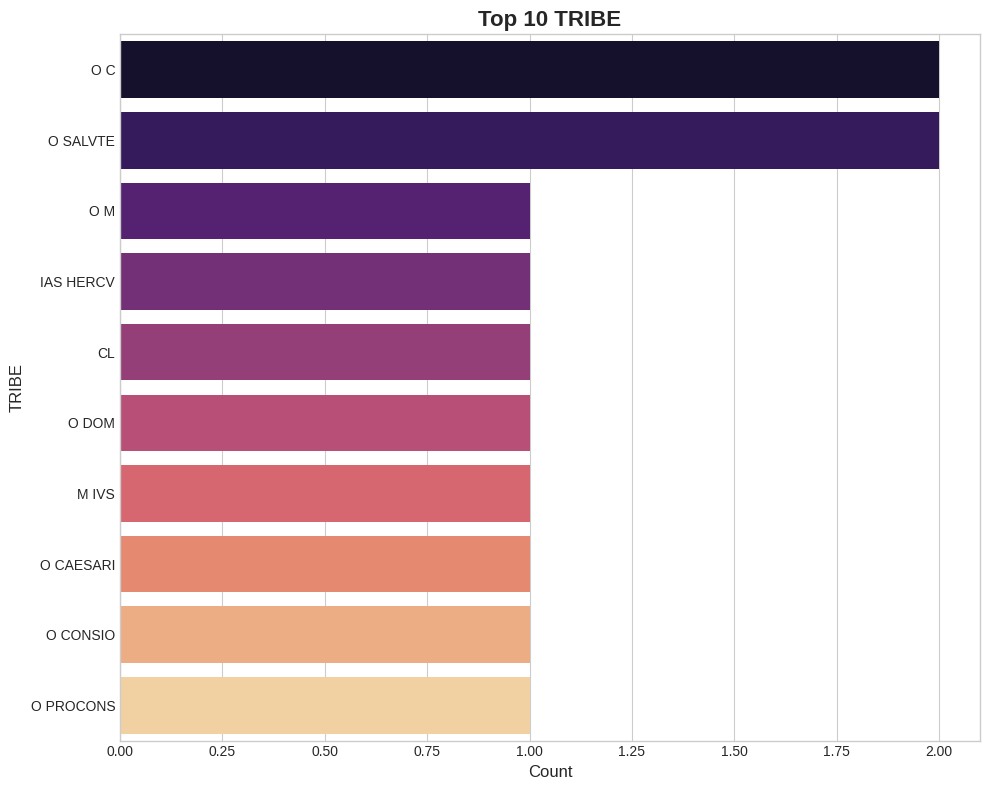



--- Visualization 2: Top 10 Most Common Military Unit ---


/tmp/ipython-input-2836028133.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_occupations.values, y=top_occupations.index, orient='h', palette='magma')


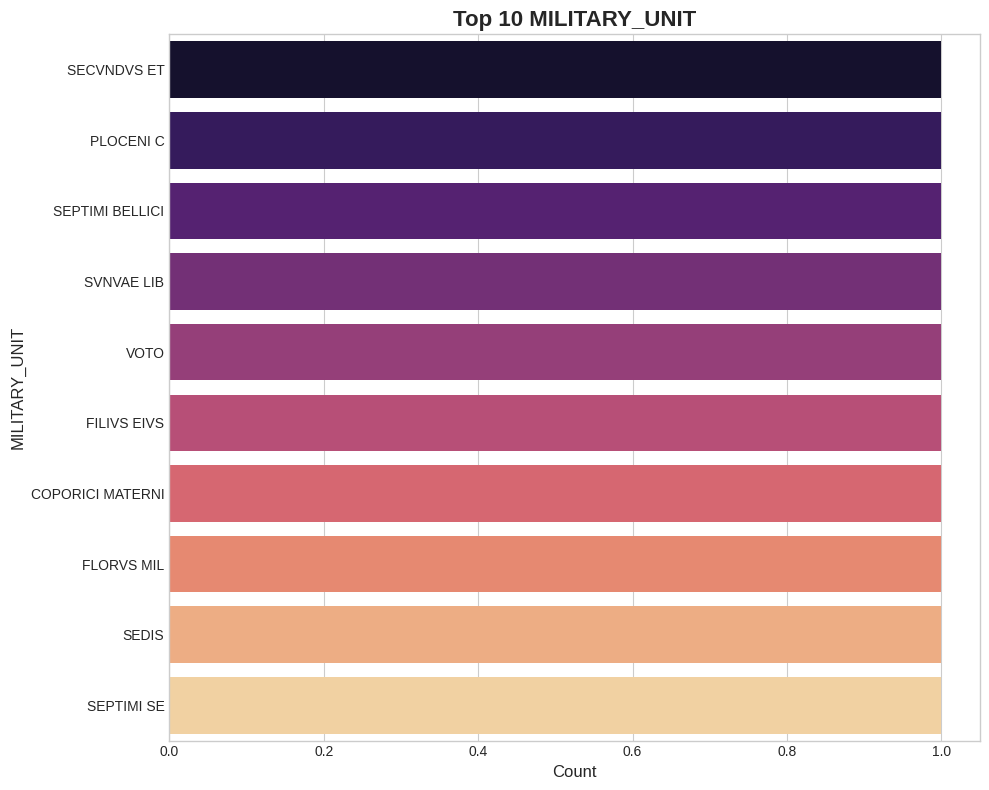

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
import re
from collections import Counter
import io

# --- Helper function to convert Roman numerals AND Latin words to integers ---
def convert_latin_age_to_int(age_str: str) -> int:
    """
    Converts an age from a Latin inscription (Roman numeral or word) to an integer.
    Handles errors gracefully by returning 0 for invalid inputs.
    """
    if not isinstance(age_str, str):
        return 0

    # Standardize the input string and handle common endings
    processed_age_str = age_str.strip().upper().rstrip('.;,')

    # 1. Check for Latin number words first
    LATIN_WORDS_TO_INT = {
        'UNUM': 1, 'DUO': 2, 'DUOBUS': 2, 'TRES': 3, 'TRIBUS': 3, 'QUATTUOR': 4,
        'QUINQUE': 5, 'SEX': 6, 'SEPTEM': 7, 'OCTO': 8, 'NOVEM': 9, 'DECEM': 10,
        'UNDECIM': 11, 'DUODECIM': 12, 'TREDECIM': 13, 'QUATTUORDECIM': 14,
        'QUINDECIM': 15, 'SEDECIM': 16, 'SEPTENDECIM': 17, 'DUODEVIGINTI': 18,
        'UNDEVIGINTI': 19, 'VIGINTI': 20, 'TRIGINTA': 30, 'QUADRAGINTA': 40,
        'QUINQUAGINTA': 50, 'SEXAGINTA': 60, 'SEPTUAGINTA': 70, 'OCTOGINTA': 80,
        'NONAGINTA': 90, 'CENTUM': 100
    }

    if processed_age_str in LATIN_WORDS_TO_INT:
        return LATIN_WORDS_TO_INT[processed_age_str]

    # 2. If it's not a word, try parsing as a Roman numeral
    roman_map = {'I': 1, 'V': 5, 'X': 10, 'L': 50, 'C': 100, 'D': 500, 'M': 1000}
    val = 0
    try:
        for i in range(len(processed_age_str)):
            if i > 0 and roman_map[processed_age_str[i]] > roman_map[processed_age_str[i-1]]:
                val += roman_map[processed_age_str[i]] - 2 * roman_map[processed_age_str[i-1]]
            else:
                val += roman_map[processed_age_str[i]]
        return val
    except KeyError:
        return 0

def visualize_ner_results(
    results_df: pd.DataFrame,
    num_examples_to_render: int = 5,
    top_n_occupations: int = 10
):
    """
    Reads a wide-format DataFrame of NER results and generates visualizations.
    This version correctly handles ages as Latin words and semicolon-separated values.
    """
    if not isinstance(results_df, pd.DataFrame):
        print("❌ Error: Input must be a pandas DataFrame.")
        return

    # --- 1. Visualization: Entity Type Frequency ---
    print("--- Visualization 1: Entity Type Frequency ---")
    entity_columns = [col for col in results_df.columns if col not in ['id', 'text', 'transcription', 'clean_text']]
    entity_counts = results_df[entity_columns].count().sort_values(ascending=False)

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 8))
    sns.barplot(x=entity_counts.index, y=entity_counts.values, palette="viridis")
    plt.title('Frequency of Each Entity Type', fontsize=16, weight='bold')
    plt.ylabel('Total Count', fontsize=12)
    plt.xlabel('Entity Type', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    print("\n")

    # --- 2. Visualization: Top N Nomen ---
    print(f"--- Visualization 2: Top {top_n_occupations} Most Common Nomen ---")
    if 'NOMEN' in results_df.columns and not results_df['NOMEN'].isnull().all():
        # Explode the semicolon-separated strings into separate rows
        occupations = results_df['NOMEN'].dropna().str.split(';').explode().str.strip()
        top_occupations = occupations.value_counts().nlargest(top_n_occupations)

        plt.figure(figsize=(10, 8))
        sns.barplot(x=top_occupations.values, y=top_occupations.index, orient='h', palette='magma')
        plt.title(f'Top {top_n_occupations} NOMEN', fontsize=16, weight='bold')
        plt.xlabel('Count', fontsize=12)
        plt.ylabel('NOMEN', fontsize=12)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ 'NOMEN' column not found or is empty. Skipping this visualization.")
    print("\n")

    # --- 3. Visualization: Age Distribution (with updated conversion) ---
    print("--- Visualization 3: Age Distribution of the Deceased ---")
    if 'AGE_YEARS' in results_df.columns and not results_df['AGE_YEARS'].isnull().all():
        # Explode semicolon-separated values, then apply the conversion function
        ages_str = results_df['AGE_YEARS'].dropna().str.split(';').explode().str.strip()
        ages_int = ages_str.apply(convert_latin_age_to_int)
        valid_ages = ages_int[(ages_int > 0) & (ages_int <= 120)]

        if not valid_ages.empty:
            plt.figure(figsize=(12, 7))
            sns.histplot(valid_ages, bins=30, kde=True, color='teal')
            plt.title('Distribution of Deceased Ages (in Years)', fontsize=16, weight='bold')
            plt.xlabel('Age (Years)', fontsize=12)
            plt.ylabel('Number of Inscriptions', fontsize=12)
            plt.tight_layout()
            plt.show()
        else:
            print("⚠️ No valid ages could be converted from the 'AGE_YEARS' column.")
    else:
        print("⚠️ 'AGE_YEARS' column not found. Skipping age distribution plot.")
    print("\n")

  # --- 4. Visualization: Top N Tribe ---
    print(f"--- Visualization 2: Top {top_n_occupations} Most Common Tribe ---")
    if 'TRIBE' in results_df.columns and not results_df['TRIBE'].isnull().all():
        # Explode the semicolon-separated strings into separate rows
        occupations = results_df['TRIBE'].dropna().str.split(';').explode().str.strip()
        top_occupations = occupations.value_counts().nlargest(top_n_occupations)

        plt.figure(figsize=(10, 8))
        sns.barplot(x=top_occupations.values, y=top_occupations.index, orient='h', palette='magma')
        plt.title(f'Top {top_n_occupations} TRIBE', fontsize=16, weight='bold')
        plt.xlabel('Count', fontsize=12)
        plt.ylabel('TRIBE', fontsize=12)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ 'TRIBE' column not found or is empty. Skipping this visualization.")
    print("\n")

  # --- 5. Visualization: Top N Military Unit ---
    print(f"--- Visualization 2: Top {top_n_occupations} Most Common Military Unit ---")
    if 'TRIBE' in results_df.columns and not results_df['MILITARY_UNIT'].isnull().all():
        # Explode the semicolon-separated strings into separate rows
        occupations = results_df['MILITARY_UNIT'].dropna().str.split(';').explode().str.strip()
        top_occupations = occupations.value_counts().nlargest(top_n_occupations)

        plt.figure(figsize=(10, 8))
        sns.barplot(x=top_occupations.values, y=top_occupations.index, orient='h', palette='magma')
        plt.title(f'Top {top_n_occupations} MILITARY_UNIT', fontsize=16, weight='bold')
        plt.xlabel('Count', fontsize=12)
        plt.ylabel('MILITARY_UNIT', fontsize=12)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ 'MILITARY_UNIT' column not found or is empty. Skipping this visualization.")
    print("\n")

visualize_ner_results(results_df)

...alright. SIGH. There are problems. But it's amazing how far you can get with synthetic data.